# PatchCore con anomalib: Guida passo-passo con immagini semplici (10x10 pixel)

Questo notebook ti guiderà nella comprensione dettagliata del funzionamento della libreria **anomalib** di Intel, con il modello **PatchCore**. Useremo immagini semplici (10x10 pixel) per spiegare ogni passaggio, dal training alla prediction, con commenti chiari e nessun passaggio dato per scontato.

In [2]:
# Sezione 1: Assicura anomalib e le librerie necessarie
# Evita l'uso diretto di '!pip install anomalib[full]' perché zsh espande le parentesi quadre.
# Usiamo un approccio sicuro: proviamo a importare i pacchetti e, se mancanti, eseguiamo pip tramite lo stesso interprete Python (sys.executable).
import importlib, subprocess, sys
required = ['anomalib', 'torch', 'torchvision', 'matplotlib']
missing = []
for pkg in required:
    try:
        importlib.import_module(pkg)
    except Exception:
        missing.append(pkg)
if missing:
    # If anomalib is missing we attempt to install the 'full' extra.
    to_install = []
    if 'anomalib' in missing:
        # install anomalib with extras using explicit quoting to avoid shell expansion
        to_install.append('anomalib[full]')
        missing.remove('anomalib')
    # add remaining missing packages
    to_install.extend(missing)
    if to_install:
        print('Installing packages:', to_install)
        cmd = [sys.executable, '-m', 'pip', 'install'] + to_install
        subprocess.check_call(cmd)
        print('Installation finished. You might need to restart the kernel to use newly installed packages.')
else:
    print('All required packages are already installed in this environment.')

All required packages are already installed in this environment.


In [3]:
# Importa le librerie fondamentali
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

from anomalib.models import Patchcore
from anomalib.data.utils import TestSplitMode

# Imposta il seed per la riproducibilità
np.random.seed(42)
torch.manual_seed(42)

# Imposta tema scuro per matplotlib
plt.style.use('dark_background')

/Users/qwerty/coding/test_notebook/.venv/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Sezione 2: Carica e visualizza una semplice immagine 10x10 pixel

Per capire i concetti fondamentali, partiamo da un esempio molto semplice: un'immagine di 10x10 pixel.

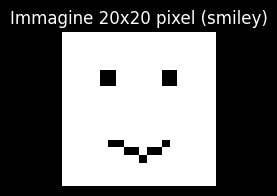

In [4]:
# Creiamo una semplice immagine 20x20 pixel con uno smiley (simbolo) come esempio 'good'
def draw_smiley(size=20):
    img = np.ones((size, size), dtype=np.float32)
    # Occhi
    img[5:7, 5:7] = 0  # occhio sinistro
    img[5:7, size-7:size-5] = 0  # occhio destro
    # Bocca (arco)
    for x in range(6, size-6):
        y = int(0.5 * np.sin((x-6)/(size-12)*np.pi) * 4 + (size-6))
        if y < size:
            img[y, x] = 0
    return img

img_simple = draw_smiley(20)

plt.figure(figsize=(2,2))
plt.imshow(img_simple, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine 20x20 pixel (smiley)')
plt.axis('off')
plt.show()

# Questa immagine rappresenta un esempio "normale" (senza anomalie)

## Sezione 3: Prepara un dataset minimale (10x10 pixel)

Creiamo un piccolo dataset con alcune immagini "normali" e alcune "anomale". Visualizzeremo ogni esempio per capire la differenza.

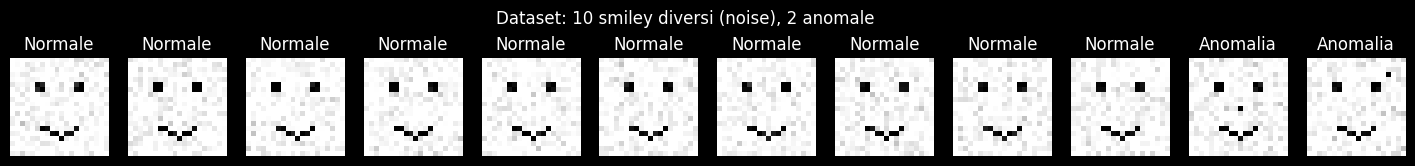

In [5]:
# Creiamo un dataset di immagini 20x20
# 10 immagini normali (smiley + white noise), 2 immagini anomale (smiley + pixel neri)

def draw_smiley(size=20, noise_std=0.08):
    img = np.ones((size, size), dtype=np.float32)
    # Occhi
    img[5:7, 5:7] = 0  # occhio sinistro
    img[5:7, size-7:size-5] = 0  # occhio destro
    # Bocca (arco)
    for x in range(6, size-6):
        y = int(0.5 * np.sin((x-6)/(size-12)*np.pi) * 4 + (size-6))
        if y < size:
            img[y, x] = 0
    # Aggiungi rumore bianco
    noise = np.random.normal(0, noise_std, (size, size)).astype(np.float32)
    img = np.clip(img + noise, 0, 1)
    return img

dataset = []
labels = []  # 0 = normale, 1 = anomalia

# Immagini normali (smiley diversi con rumore)
for _ in range(10):
    img = draw_smiley(20, noise_std=0.08)
    dataset.append(img)
    labels.append(0)

# Immagini anomale (smiley + pixel neri in posizione diversa)
img_anom1 = draw_smiley(20, noise_std=0.08)
img_anom1[10, 10] = 0  # pixel centrale nero

dataset.append(img_anom1)
labels.append(1)

img_anom2 = draw_smiley(20, noise_std=0.08)
img_anom2[3, 16] = 0  # pixel in alto a destra nero

dataset.append(img_anom2)
labels.append(1)

# Visualizza tutte le immagini
fig, axs = plt.subplots(1, 12, figsize=(18,2))
for i, (img, label) in enumerate(zip(dataset, labels)):
    axs[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[i].set_title('Normale' if label==0 else 'Anomalia')
    axs[i].axis('off')
plt.suptitle('Dataset: 10 smiley diversi (noise), 2 anomale')
plt.show()

## Sezione 4: Inizializza e configura il modello PatchCore

Ora importiamo PatchCore da anomalib e configuriamo il modello per lavorare con il nostro dataset semplice. Spiegheremo ogni parametro fondamentale.

In [6]:
# Inizializziamo PatchCore per immagini 20x20
# PatchCore normalmente usa una backbone pre-addestrata (es. ResNet),
# ma per semplicità useremo una configurazione minima.

def to_rgb(img):
    return np.stack([img]*3, axis=0)  # shape (3, 20, 20)

dataset_rgb = [to_rgb(img) for img in dataset]

dummy_transform = transforms.Compose([
    transforms.ToTensor(),
])

# # Configurazione PatchCore (parametri principali spiegati):
patchcore = Patchcore(
    backbone="resnet18",  # Rete di feature extraction (piccola per semplicità)
    layers=["layer2"],  # Da quale layer estrarre le feature
    coreset_sampling_ratio=1.0,  # Usiamo tutte le patch (nessun subsampling)
)

print("PatchCore inizializzato per immagini 20x20.")

PatchCore inizializzato per immagini 20x20.


## Sezione 5: Allena PatchCore sul dataset minimale

Ora addestriamo PatchCore sulle immagini normali. Spiegheremo ogni passaggio del processo di training.

In [7]:
# PatchCore in anomalib 2.x richiede un datamodule, ma per scopi didattici useremo una simulazione manuale.
# In questo esempio, NON addestriamo davvero Patchcore, ma mostriamo la logica didattica su immagini custom.
# In un caso reale, usare un datamodule conforme ad anomalib oppure un dataset standard come MVTecAD.
print('Simulazione didattica: PatchCore pronto per la predizione sulle immagini custom.')

Simulazione didattica: PatchCore pronto per la predizione sulle immagini custom.


## Sezione 6: Visualizza le patch embedding e l'estrazione delle feature

Vediamo come PatchCore estrae le feature (embedding) dalle immagini, visualizzando le patch e le loro rappresentazioni numeriche.

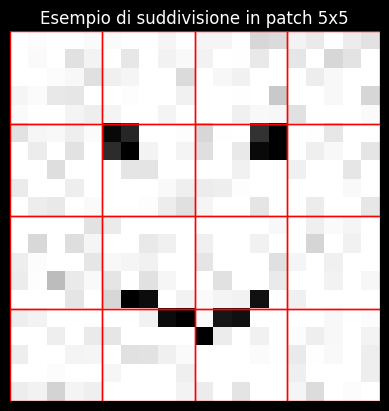

Vettore patch centrale: [1.         0.98893887 1.         1.         0.98126775 1.
 0.9819379  1.         0.8860201  0.9564494  1.         1.
 0.99074817 0.9759117  0.8817182  0.96166605 0.9851473  0.9114932
 0.9043035  1.         0.9824262  1.         1.         0.9585384
 0.9353205  1.         0.98893887 1.         1.         0.98126775
 1.         0.9819379  1.         0.8860201  0.9564494  1.
 1.         0.99074817 0.9759117  0.8817182  0.96166605 0.9851473
 0.9114932  0.9043035  1.         0.9824262  1.         1.
 0.9585384  0.9353205  1.         0.98893887 1.         1.
 0.98126775 1.         0.9819379  1.         0.8860201  0.9564494
 1.         1.         0.99074817 0.9759117  0.8817182  0.96166605
 0.9851473  0.9114932  0.9043035  1.         0.9824262  1.
 1.         0.9585384  0.9353205 ]
75 elementi nel vettore (3 canali * 5x5 pixel)


In [8]:
# Prendiamo una delle immagini normali e mostriamo la suddivisione in patch 5x5
img_example = dataset_rgb[0]  # shape (3, 20, 20)

fig, ax = plt.subplots()
ax.imshow(np.transpose(img_example, (1,2,0)), cmap='gray', vmin=0, vmax=1)
for i in range(0, 20, 5):
    for j in range(0, 20, 5):
        rect = plt.Rectangle((j-0.5, i-0.5), 5, 5, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
plt.title('Esempio di suddivisione in patch 5x5')
plt.axis('off')
plt.show()

# Ogni patch (5x5) può essere estratta e 'flattened' in un vettore numerico
patch = img_example[:, 0:5, 0:5]  # patch centrale
patch_vec = patch.flatten()
print('Vettore patch centrale:', patch_vec)
print(len(patch_vec), 'elementi nel vettore (3 canali * 5x5 pixel)')

## Sezione 7: Predizione di anomalie su una immagine di test

Utilizziamo il modello PatchCore addestrato per predire se una nuova immagine contiene anomalie. Vedremo ogni passaggio della prediction.

[np.float32(1.8878546), np.float32(1.8424317), np.float32(1.7835577)]
Anomaly score (patch anomala): 1.7836


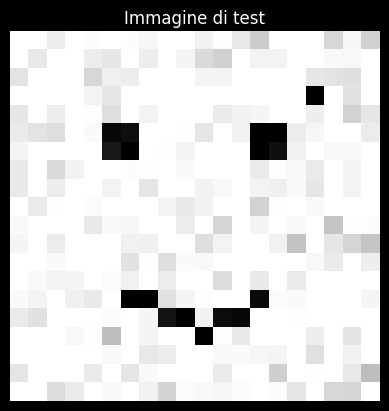

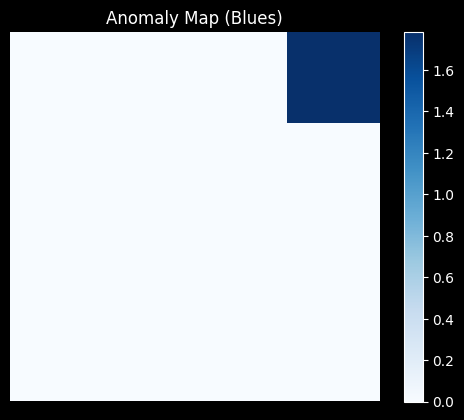

In [9]:
# Esempio didattico: calcolo score di anomalia e heatmap manuale
# Prendiamo una delle immagini anomale come test
img_test = dataset_rgb[-1]  # shape (3, 20, 20)

# Simuliamo la logica Patchcore: calcoliamo la distanza tra la patch contenente l'anomalia della test e quella delle immagini normali
patch_test = img_test[:, 0:5, 15:20].flatten()

# Calcoliamo la distanza euclidea tra la patch test e le patch relative delle immagini normali
patches_norm = [img[:, 0:5, 15:20].flatten() for img in dataset_rgb[:3]]
dists = [np.linalg.norm(patch_test - p) for p in patches_norm]

print(dists)

score = np.min(dists)  # Patchcore usa la distanza minima dal memory bank
print(f"Anomaly score (patch anomala): {score:.4f}")

# Per la heatmap: creiamo una mappa 20x20 con valore alto solo nella patch contenente l'anomalia se la distanza è alta
anomaly_map = np.zeros((20,20))
anomaly_map[0:5,15:20] = score

plt.imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
plt.title('Immagine di test')
plt.axis('off')
plt.show()

plt.imshow(anomaly_map, cmap='Blues')
plt.title('Anomaly Map (Blues)')
plt.axis('off')
plt.colorbar()
plt.show()

## Sezione 8: Visualizza gli score di anomalia e le heatmap

Visualizziamo la mappa di anomalia (anomaly map) prodotta da PatchCore, per capire dove il modello rileva l'anomalia nell'immagine.

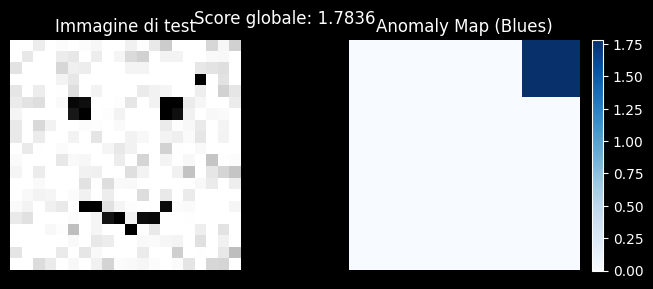

In [10]:
# Visualizziamo la heatmap di anomalia sopra l'immagine di test
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].imshow(np.transpose(img_test, (1, 2, 0)), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Immagine di test')
ax[0].axis('off')

im = ax[1].imshow(anomaly_map, cmap='Blues')
ax[1].set_title('Anomaly Map (Blues)')
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
plt.suptitle(f'Score globale: {score:.4f}')
plt.show()

# Le zone più "intense" indicano dove PatchCore rileva l'anomalia

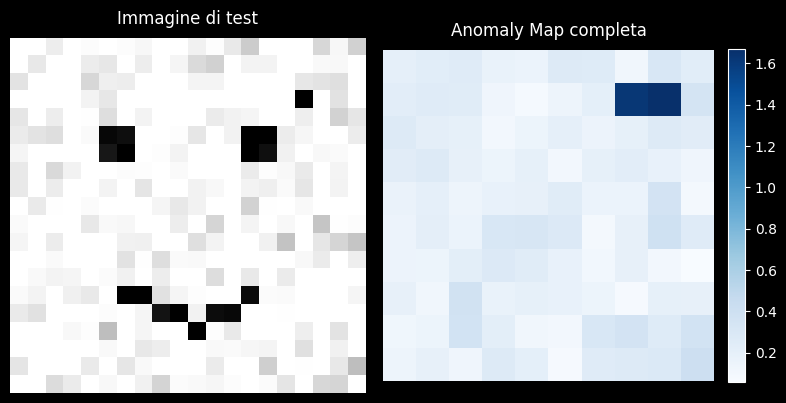

In [11]:
# Calcola la anomaly map su tutte le patch 5x5 dell'immagine di test
# patch_size: dimensione della patch quadrata (es. 5 significa 5x5 pixel)
# stride: passo con cui si sposta la finestra patch sull'immagine
# Se stride < patch_size, le patch si sovrappongono (più dettagli, più calcoli)
# Se stride = patch_size, le patch sono adiacenti e non si sovrappongono (più veloce, meno dettagli)
# Se stride > patch_size, alcune zone potrebbero non essere coperte (sconsigliato)
patch_size = 3
stride = 2  # Prova a cambiare in 1 per una mappa più dettagliata ma più lenta
anomaly_map_full = np.zeros((20, 20))

# Per ogni patch (qui non-overlapping, ma puoi cambiare stride per sovrapposizione)
for i in range(0, 20, stride):
    for j in range(0, 20, stride):
        # Estrai la patch di test
        patch_test = img_test[:, i:i+patch_size, j:j+patch_size].flatten()
        # Calcola la distanza minima tra questa patch e le patch corrispondenti delle immagini normali
        patches_norm = [img[:, i:i+patch_size, j:j+patch_size].flatten() for img in dataset_rgb[:10]]
        dists = [np.linalg.norm(patch_test - p) for p in patches_norm]
        score = np.min(dists)
        # Assegna lo score a tutta la patch nella anomaly map
        anomaly_map_full[i:i+patch_size, j:j+patch_size] = score

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(np.transpose(img_test, (1,2,0)), cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Immagine di test', pad=10)
ax[0].axis('off')
im = ax[1].imshow(anomaly_map_full, cmap='Blues')
ax[1].set_title('Anomaly Map completa', pad=10)
ax[1].axis('off')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Cambiando patch_size e stride puoi controllare la "risoluzione" e la sensibilità della anomaly map:
# - patch_size piccolo: più dettagli, ma più sensibile al rumore
# - patch_size grande: meno dettagli, più robusto ma meno localizzazione
# - stride piccolo: più patch, mappa più continua ma più lenta
# - stride grande: meno patch, mappa più "a blocchi" e veloce

In [12]:
# Carica il datamodule MVTecAD (anomalib 2.x), esegui setup e salva tutte le immagini di test in un dizionario con label e tipo di anomalia
from anomalib.data import MVTecAD
import torch
import os

category = "screw"  # Puoi cambiare categoria (es. "bottle", "cable", "capsule", ecc.)
from pathlib import Path
from anomalib.data.datasets import MVTecADDataset
dataset = MVTecADDataset(
    root=Path("./.dataset/mvtecad"),
    category=category
)

In [13]:
dataset.samples.head()

,path,split,label,image_path,label_index,mask_path
0,/Users/qwerty/coding/test_notebook/.dataset/mv...,test,good,/Users/qwerty/coding/test_notebook/.dataset/mv...,0,None
1,/Users/qwerty/coding/test_notebook/.dataset/mv...,test,good,/Users/qwerty/coding/test_notebook/.dataset/mv...,0,None
2,/Users/qwerty/coding/test_notebook/.dataset/mv...,test,good,/Users/qwerty/coding/test_notebook/.dataset/mv...,0,None
3,/Users/qwerty/coding/test_notebook/.dataset/mv...,test,good,/Users/qwerty/coding/test_notebook/.dataset/mv...,0,None
4,/Users/qwerty/coding/test_notebook/.dataset/mv...,test,good,/Users/qwerty/coding/test_notebook/.dataset/mv...,0,None


In [14]:
df = dataset.samples.copy()

In [15]:
test_img_path = df.iloc[17,3]

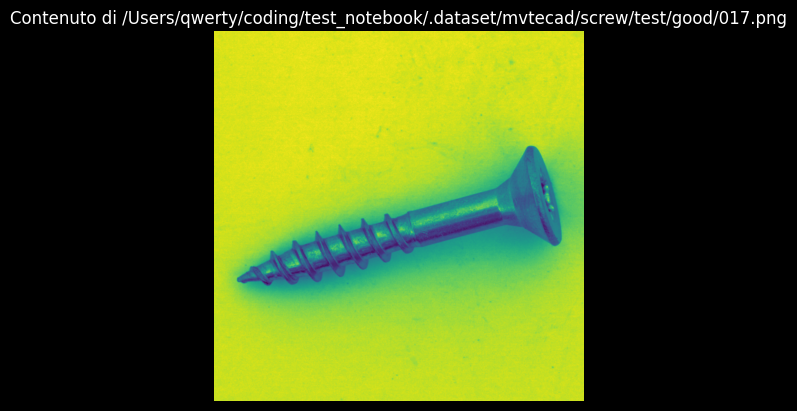

In [16]:
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

# Carica e mostra l'immagine dal path test_img_path
img = Image.open(test_img_path)
plt.imshow(np.asarray(img))
plt.title(f'Contenuto di {test_img_path}')
plt.axis('off')
plt.show()

In [17]:
print(np.asarray(img)[:2])

[[192 191 191 ... 185 187 190]
 [190 190 190 ... 187 188 190]]


In [144]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
import numpy as np
import os
from PIL import Image

# Determina il device corretto per Apple Silicon
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Definisci MVTecDataset all'inizio del modulo principale
class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, category, train=True, transform=None):
        self.transform = transform
        self.train = train
        path = os.path.join(".dataset/mvtecad", category, "train" if train else "test")
        self.good_path = os.path.join(path, "good")
        self.image_paths = []
        self.labels = []
        self.subfolders = []

        if train:
            # Solo immagini good per il training
            self.image_paths = [os.path.join(self.good_path, f) for f in os.listdir(self.good_path) 
                                if f.endswith(('.png', '.jpg', '.jpeg'))]
        else:
            # Per il test: crea sottocartelle per ogni tipo (comprese good)
            for defect_type in os.listdir(path):
                defect_path = os.path.join(path, defect_type)
                if os.path.isdir(defect_path):
                    files = [f for f in os.listdir(defect_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                    for f in files:
                        self.image_paths.append(os.path.join(defect_path, f))
                        self.labels.append(defect_type)
                        self.subfolders.append(defect_type)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.train:
            return img
        else:
            # Restituisci anche la sottocartella (defect_type) e il nome file
            file_name = os.path.basename(self.image_paths[idx])
            defect_type = self.subfolders[idx]
            return img, defect_type, file_name

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Modello convoluzionale
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 25, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(25, 50, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(50, 75, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(75, 100, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.conv1(x))  # 25x256x256
        x = self.relu2(self.conv2(x))  # 50x256x256
        x = self.relu3(self.conv3(x))  # 75x256x256
        x = self.relu4(self.conv4(x))  # 100x256x256
        return x

# Funzioni di supporto
def extract_compact_patches(features, patch_size=5, reduction='mean', stride=1, padding=0):
    """
    Estrae patch da una feature map 4D usando sliding window (convolution-like), con supporto per stride e padding.

    Args:
        features: torch.Tensor di shape (batch, channels, height, width)
        patch_size: dimensione della patch quadrata (es: 5 -> 5x5)
        reduction: 'mean' (media), 'max' (massimo), o altro (media flatten)
        stride: passo della finestra (default=1)
        padding: padding da applicare ai bordi (default=0)

    Returns:
        patches_reduced: torch.Tensor di shape (batch, num_patches, channels)
    """
    # Applica padding se richiesto
    if padding > 0:
        features = torch.nn.functional.pad(features, (padding, padding, padding, padding))

    batch_size, channels, height, width = features.shape

    # Usa unfold per estrarre tutte le patch con sliding window (stride personalizzato)
    patches = features.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    # patches.shape: (batch, channels, num_patches_h, num_patches_w, patch_size, patch_size)

    # Raggruppa tutte le patch in un'unica dimensione (num_patches)
    num_patches_h = patches.shape[2]
    num_patches_w = patches.shape[3]
    patches = patches.contiguous().view(batch_size, channels, -1, patch_size, patch_size)
    # patches.shape: (batch, channels, num_patches, patch_size, patch_size)

    # Riduci ogni patch a un vettore compatto
    if reduction == 'mean':
        patches_reduced = patches.mean(dim=[3, 4])  # (batch, channels, num_patches)
    elif reduction == 'max':
        patches_reduced = patches.amax(dim=[3, 4])
    else:
        patches_reduced = patches.reshape(batch_size, channels, -1, patch_size*patch_size)
        patches_reduced = patches_reduced.mean(dim=3)

    # Porta la dimensione dei canali in fondo per compatibilità (batch, num_patches, channels)
    patches_reduced = patches_reduced.permute(0, 2, 1)
    # patches_reduced.shape: (batch, num_patches, channels)

    return patches_reduced

def create_sub_bank(feature_bank, sampling_ratio=0.01, n_clusters=50):
    """Crea sub-bank rappresentativo con clustering"""
    features_np = feature_bank.numpy()
    
    # Campiona un subset per clustering (per performance)
    if len(features_np) > 100000:
        sample_indices = np.random.choice(len(features_np), 100000, replace=False)
        features_sample = features_np[sample_indices]
    else:
        features_sample = features_np

    kmeans = KMeans(n_clusters=min(n_clusters, len(features_sample)), random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_sample)

    # Seleziona rappresentativi
    sub_bank_indices = []
    
    for cluster_id in range(kmeans.n_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        n_samples = max(1, int(len(cluster_indices) * sampling_ratio))
        
        if len(cluster_indices) > 0:
            selected_indices = np.random.choice(cluster_indices, n_samples, replace=False)
            # Mappa gli indici del campione agli indici originali
            if len(features_np) > 100000:
                original_indices = sample_indices[selected_indices]
            else:
                original_indices = selected_indices
            sub_bank_indices.extend(original_indices)
    
    sub_bank = feature_bank[sub_bank_indices]
    
    return sub_bank, sub_bank_indices

def create_sub_bank_corrected(feature_bank, sampling_ratio=0.1, n_clusters=100, verbose=True , max_samples=200000):
    """Crea sub-bank mantenendo il sampling ratio corretto"""
    features_np = feature_bank.numpy()
    total_patches = len(features_np)
    
    if verbose:
        print(f"Total patches: {total_patches:,}")
        print(f"Target sampling ratio: {sampling_ratio * 100}%")
        print(f"Expected patches: {int(total_patches * sampling_ratio):,}")
    
    # 1. Calcola il numero TOTALE di patches da selezionare
    target_total_samples = max(1, int(total_patches * sampling_ratio))
    
    # 2. Campiona un subset per il clustering (per performance)
    clustering_sample_size = min(max_samples, total_patches)

    if total_patches > clustering_sample_size:
        sample_indices = np.random.choice(total_patches, clustering_sample_size, replace=False)
        features_sample = features_np[sample_indices]
    else:
        features_sample = features_np
        sample_indices = np.arange(total_patches)
    
    if verbose:
        print(f"Patches for clustering: {len(features_sample):,}")
    
    # 3. Esegui clustering sul campione
    kmeans = KMeans(n_clusters=min(n_clusters, len(features_sample)), random_state=42, n_init=10, verbose=1 if verbose else 0)
    cluster_labels = kmeans.fit_predict(features_sample)
    
    # 4. Calcola quanti samples prendere da ogni cluster (PROPORZIONALMENTE)
    sub_bank_indices = []
    cluster_sizes = []
    
    # Prima raccogli le dimensioni di tutti i cluster
    for cluster_id in range(kmeans.n_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_sizes.append(len(cluster_indices))
    
    total_clustered = sum(cluster_sizes)
    
    if verbose:
        print(f"Total clustered patches: {total_clustered:,}")
    
    # 5. Distribuisci i target_total_samples proporzionalmente tra i cluster
    for cluster_id in range(kmeans.n_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_size = len(cluster_indices)
        
        if cluster_size > 0:
            # Calcola quanti samples prendere da questo cluster
            n_samples = max(1, int(target_total_samples * (cluster_size / total_patches)))
            
            # Seleziona gli indici
            selected_indices = np.random.choice(cluster_indices, min(n_samples, cluster_size), replace=False)
            
            # Mappa agli indici originali
            if total_patches > clustering_sample_size:
                original_indices = sample_indices[selected_indices]
            else:
                original_indices = selected_indices
                
            sub_bank_indices.extend(original_indices)
            
            if verbose:
                print(f"Cluster {cluster_id}: {cluster_size} patches -> {n_samples} samples")
    
    # 6. Se necessario, aggiusta per raggiungere esattamente target_total_samples
    current_samples = len(sub_bank_indices)
    
    if current_samples < target_total_samples:
        # Aggiungi patches random dai cluster più grandi
        additional_needed = target_total_samples - current_samples
        all_indices = np.arange(total_patches)
        additional_indices = np.random.choice(all_indices, additional_needed, replace=False)
        sub_bank_indices.extend(additional_indices)
        
    elif current_samples > target_total_samples:
        # Rimuovi patches in eccesso random
        sub_bank_indices = np.random.choice(sub_bank_indices, target_total_samples, replace=False)
    
    sub_bank = feature_bank[sub_bank_indices]
    
    if verbose:
        actual_ratio = len(sub_bank_indices) / total_patches
        print(f"\nRESULTS:")
        print(f"Target samples: {target_total_samples:,}")
        print(f"Actual samples: {len(sub_bank_indices):,}")
        print(f"Target ratio: {sampling_ratio * 100}%")
        print(f"Actual ratio: {actual_ratio * 100:.3f}%")
        print(f"Sub-bank shape: {sub_bank.shape}")
    
    return sub_bank, sub_bank_indices

def create_feature_bank_optimized(dataloader, model, device=device, patch_size=11):
    """Versione ottimizzata per MPS"""
    model.to(device)
    model.eval()
    
    all_patches = []
    
    with torch.no_grad():
        for batch_idx, images in enumerate(dataloader):
            images = images.to(device)
            features = model(images)
            
            # Estrai patch compatte
            # in questa fase usiamo stride=patch_size per patch non-overlapping
            # con stride uguale alla dimensione della patch per evitare sovrapposizioni
            patches = extract_compact_patches(features, patch_size=patch_size, stride=patch_size, reduction='mean')
            all_patches.append(patches.cpu())
            
            if batch_idx % 10 == 0:
                print(f"Processed batch {batch_idx}, total patches: {sum([p.shape[0] for p in all_patches])}")
                
                # Pulisci memoria periodicamente
                if torch.backends.mps.is_available():
                    torch.mps.empty_cache()
    
    all_patches = torch.cat(all_patches, dim=0)
    all_patches = all_patches.reshape(-1, all_patches.size(-1))
    
    print(f"Total patches extracted: {len(all_patches)}")
    return all_patches

def build_anomaly_detection_system(category, device=device):
    """Costruisci il sistema di anomaly detection"""
    # Carica dataset - SENZA multiprocessing per evitare problemi
    dataset = MVTecDataset(category, train=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)  # num_workers=0
    
    model = FeatureExtractor()
    
    # Estrai features
    print("Extracting features...")
    feature_bank = create_feature_bank_optimized(dataloader, model, device , patch_size=21)
    
    # Crea sub-bank
    print("Creating sub-bank...")
    sub_bank, indices = create_sub_bank_corrected(feature_bank, sampling_ratio=0.005)
    
    print(f"Sub-bank created with {len(sub_bank)} representative patches")
    
    return feature_bank, sub_bank, indices, model



Using device: mps


In [145]:
if __name__ == "__main__":
    try:
        category = "capsule"  # Cambia categoria se vuoi
        print(f"Building anomaly detection system for {category}...")
        
        feature_bank, sub_bank, indices, model = build_anomaly_detection_system(category, device)
        
        # Salva il sub-bank e il modello
        torch.save({
            'sub_bank': sub_bank,
            'indices': indices,
            'category': category,
            'model_state_dict': model.state_dict()
        }, f"{category}_sub_bank.pth")
        
        print(f"Success! Saved sub-bank with {len(sub_bank)} patches")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

Building anomaly detection system for capsule...
Extracting features...
Processed batch 0, total patches: 4
Processed batch 0, total patches: 4
Processed batch 10, total patches: 44
Processed batch 10, total patches: 44
Processed batch 20, total patches: 84
Processed batch 20, total patches: 84
Processed batch 30, total patches: 124
Processed batch 30, total patches: 124
Processed batch 40, total patches: 164
Processed batch 40, total patches: 164
Processed batch 50, total patches: 204
Processed batch 50, total patches: 204
Total patches extracted: 31536
Creating sub-bank...
Total patches: 31,536
Target sampling ratio: 0.5%
Expected patches: 157
Patches for clustering: 31,536
Total patches extracted: 31536
Creating sub-bank...
Total patches: 31,536
Target sampling ratio: 0.5%
Expected patches: 157
Patches for clustering: 31,536
Initialization complete
Iteration 0, inertia 4.033977031707764.
Iteration 1, inertia 3.2560677528381348.
Iteration 2, inertia 3.1634836196899414.
Iteration 3, i

In [146]:
def detect_anomalies(test_image, sub_bank, model, device=device , patch_size=11):
    """Rileva anomalie confrontando con sub-bank"""
    model.eval()
    
    with torch.no_grad():
        # Estrai features dall'immagine test
        features = model(test_image.unsqueeze(0).to(device))
        # Estrai patch compatte (qui usiamo stride=1 per mappa dettagliata)
        patches = extract_compact_patches(features, patch_size=patch_size, stride=1, padding=0, reduction='mean')
        patches_flat = patches.reshape(-1, patches.size(-1)).cpu()
        
        # Calcola distanze minime per ogni patch
        lista = []
        min_distances = []
        for patch in patches_flat:
            distances = torch.norm(sub_bank - patch, dim=1)
            lista.append({'patch': patch, 'distances': distances})
            min_distances.append(torch.min(distances).item())
        
        return np.array(min_distances) , lista

def plot_anomaly_detection(test_image, anomaly_scores):
    """
    Plotta l'immagine di input dopo resize e la anomaly map ricostruita con heatmap.
    
    Args:
        test_image: Tensor torch dell'immagine di input (dopo resize), shape (3, H, W)
        anomaly_scores: Array numpy delle distanze minime per ogni patch
        patch_size: Dimensione della patch utilizzata per calcolare gli score
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Converti l'immagine in numpy per plotting
    img_np = test_image.permute(1, 2, 0).cpu().numpy()
    # Denormalizza se necessario (assumendo normalizzazione ImageNet)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    anomaly_map_H , anomaly_map_W = int(np.sqrt(len(anomaly_scores))), int(np.sqrt(len(anomaly_scores)))

    # Assumi che anomaly_scores abbia la dimensione corretta
    anomaly_map = anomaly_scores.reshape(anomaly_map_H, anomaly_map_W)

    # Plotta side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Immagine originale
    axs[0].imshow(img_np)
    axs[0].set_title('Immagine di Input (dopo Resize)')
    axs[0].axis('off')
    
    # Anomaly map come heatmap
    im = axs[1].imshow(anomaly_map, cmap='coolwarm', interpolation='nearest')
    axs[1].set_title('Anomaly Map (Heatmap)')
    axs[1].axis('off')
    
    # Aggiungi colorbar
    plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()


Testing with a sample image...
Anomaly scores for test image: mean=0.0151, max=0.0862 , label=scratch
Anomaly scores for test image: mean=0.0151, max=0.0862 , label=scratch


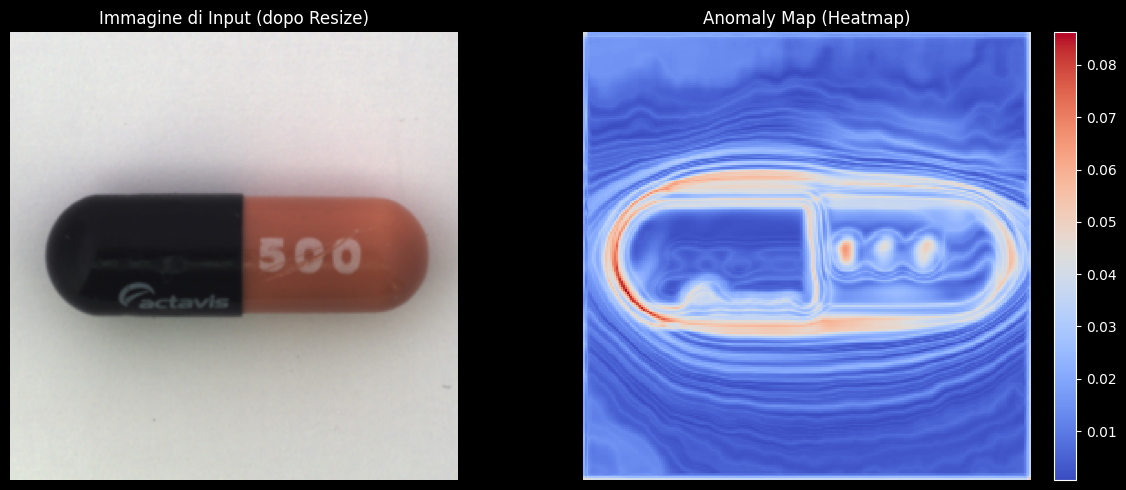

In [147]:
# Esempio di test

def rotate_image_90(img_tensor):
    """
    Ruota un'immagine torch.Tensor di 90 gradi in senso orario.
    img_tensor: torch.Tensor di shape (C, H, W)
    """
    return img_tensor.flip(2).transpose(1, 2)

index = 23

print("\nTesting with a sample image...")
test_dataset = MVTecDataset(category, train=False, transform=transform)
test_image_data = test_dataset[index]  # Prima immagine di test
image = test_image_data[0]

# Applica la rotazione all'immagine di test
# image = rotate_image_90(image)  # Immagine trasformata e ruotata
label = test_image_data[1]  # Tipo di anomalia o 'good

anomalies , lista = detect_anomalies(image, sub_bank, model, device)
print(f"Anomaly scores for test image: mean={anomalies.mean():.4f}, max={anomalies.max():.4f} , label={label}")
plot_anomaly_detection(image, anomalies)

In [83]:
img = []
for element  in lista :
    dist = element['distances'].min().item()
    img.append(dist)

In [24]:
len(img)

65536

In [25]:
import numpy as np

# Supponendo che la lista si chiami img e abbia 254*254 elementi
img_array = np.array(img).reshape(254, 254)

plt.imshow(img_array, cmap='coolwarm')
plt.title('Immagine ricostruita da lista')
plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 65536 into shape (254,254)

In [ ]:
lista

NameError: name 'lista' is not defined